## Work package 2.1 
### Delivering ...:
Methods (notebook) for compiling short-term time-series  (e.g., monthly)  of EO data for WQ monitoring: 
Filtering of outliers and inferior data (insufficient radiation, glint, shadowing, bottom-reflectance) 
Apply corrections (dark-pixel subtraction)
Define areas of water (at time of observation)
Compilation to bi-monthly and monthly values

Time-series will need to cover: 
Baseline period
Monitoring period
Time of observation (i.e., recent)


### Dependencies etc.

In [6]:
# --- --- 
import datacube
import numpy as np
import xarray as xr
import scipy as sp
import gc
from scipy import stats
import pandas as pd     #for dates

dc = datacube.Datacube(app='DoinWhatImdoin') #testing what difference the 'app' value makes...

In [7]:
# --- run code for functions that are called
%run /home/jovyan/dev/deafrica_water_quality/WP1.2/_WQ_functions.py
%run /home/jovyan/dev/deafrica_water_quality/WP1.2/_Build_annual_dataset-1.0.ipynb   #for now I have kept these functions in a notebook for the markdown

In [8]:
# --- controlling parameters and settings
verbose = True
test    = False
max_cells = 100000   #use this to test memory limits. Memory saving steps are going to be needed...

#### Set the place and time interval


In [9]:
# --- get the dictionary of all possible places for analysis ---
places_dict     = set_spacetime_domain()   
# --- extract an AOI for a given placename (could iterate through the dictionary keys as an alternative)
placename = 'SA_smalldam'   
placename = 'Lake_Sulunga'   
placename = 'Ghana_River'   
placename = 'Lake_Tikpan'   
placename = 'Lake_vic_turbid'   
placename = 'Lake_Manyara'   # a good example for monitoring - (35.7236, 35.9286) (-3.8135, -3.4085), late 2015, to 2016-02-16   
# --- the functions set_spacetime_domain is used here to set a bunch of processing parameters
# --- when operationalising, this must be replaced but an approach that iterates through tiles or waterebodiies

spacetime_domain, grid_resolution, cell_area, resampling_option, year1, year2 \
                           = set_spacetime_domain(placename,'2015-12-01','2016-03-31',max_cells,verbose,False)


Lake_Manyara AOI:  {'x': (35.724, 35.929), 'y': (-3.814, -3.409), 'time': ('2015-12-01', '2016-03-31')} Lake_Manyara, Tanzania
Grid resolution will be: (90, 90)
Rough dimensions (x,y):  20  by  40 kilometres
Total cells is roughly:  102272
Cell area is:  0.0081  km2
Resampling : nearest
Site name:  Lake_Manyara, Tanzania
Years: 2015-12-01 2016-03-31


### Extract a multi-sensor dataset 
- keeping all data in a single dataset
- a dictionary of instruments and sensors is used to rename all measurements to a common form
- instrument names are used rather than satellite names, to avoid confusion. For these purposes, wofs is also an instrument name
- re-using functions developed for the annual time-series where possible


In [10]:
# --- set which instruments to use (this is checked later against the date range for each place)
# --- The geomedians are retained as a reference for filtering of outliers.
# --- The returned dataset should have everything in one ..
# --- switch off the non-annual datasets to allow the annual build function to be used separately 

_instruments_to_use = {
    'oli_agm'  : {'use': True },
    'oli'      : {'use': False},
    'msi_agm'  : {'use': True },
    'msi'      : {'use': False},
    'tm_agm'   : {'use': True },
    'tm'       : {'use': False},
    'tirs'     : {'use': False},  
    'wofs_ann' : {'use': True },
    'wofs_all' : {'use': False },  # wofs_all will be removed as it is better to derive from wofs_ann
    }

instruments_to_use = _instruments_to_use.copy()  #using a copy is helpful sometimes..

# --- for a couple of purposes extract the year from the start and end times ..
y1 = pd.DatetimeIndex([year1]).year[0]
y2 = pd.DatetimeIndex([year2]).year[0]
 
# --- don't try to use instruments for which there are no data#

check_instrument_dates(instruments_to_use,y1,y2,False)

# --- build the multivariate/multi-sensor dataset. 
#     Datacube calls are made to extract the primary data. 
#     Variables are-re-named and merged to a single dataset ---

#build the annual dataset first:
spacetime_domain_ann = spacetime_domain.copy()
if y1 == y2: y1 = y2 - 1
spacetime_domain_ann['time'] = (str(y1),str(y2))

ds_annual =  build_wq_agm_dataset(spacetime_domain_ann,instruments_to_use,verbose)



Building the dataset:
loading data for  oli_agm ...
loading data for  wofs_ann ...


In [13]:
# --- now build the other datasets ---
# --- unfortunately load_ard is a very unscientific approach so not really useable. 

_instruments_to_use = {
    'oli_agm'  : {'use': False },
    'oli'      : {'use': True},
    'msi_agm'  : {'use': False },
    'msi'      : {'use': True},
    'tm_agm'   : {'use': False },
    'tm'       : {'use': True},
    'tirs'     : {'use': True},  
    'wofs_ann' : {'use': False },
    'wofs_all' : {'use': False },  # wofs_all will be removed as it is better to derive from wofs_ann
    }
instruments_to_use = _instruments_to_use.copy()  #using a copy is helpful sometimes..

y1 = pd.DatetimeIndex([year1]).year[0]
y2 = pd.DatetimeIndex([year2]).year[0]

check_instrument_dates(instruments_to_use,y1,y2,False)

products = { 
                'tm_agm'  :["gm_ls5_ls7_annual"],
                'tm'      :["ls5_sr","ls7_sr"],
                'oli_agm' :["gm_ls8_annual","gm_ls8_ls9_annual"],
                'oli'     :["ls8_sr","ls9_sr"],
                'msi_agm' :["gm_s2_annual"],
                'msi'     :["s2_l2a"],
                'tirs'    :["ls5_st","ls7_st","ls8_st","ls9_st"],
                'wofs_ann':["wofs_ls_summary_annual"],
                'wofs_all':["wofs_ls_summary_alltime"],
               }

instruments,measurements,rename_dict = instruments_list(instruments_to_use) 

if instruments_to_use['oli']['use']:
    print('building the oli dataset')
    instrument = 'oli'
    # --- load oli data
    # Load available data from all three Landsat satellites
    ds_oli = dc.load(product=(products[instrument]),
                                 **spacetime_domain,
                                 **{'measurements': measurements[instrument]},
                                 output_crs='epsg:6933',
                                 group_by ='solar_day',
                                 resolution=grid_resolution,
                                 align=(0,0),
                                 resampling=resampling_option,)
    # --- re-name the variables for the sake of sanity --- 
    ds_oli = rename_vars_robust(ds_oli,rename_dict['oli'])
    # --- set zeros to nans and re-scale 
    for var in ds_oli.data_vars:
        ds_oli[var] = xr.where(ds_oli[var]>0,ds_oli[var],np.nan)
        if not var == 'oli_pq':
            ds_oli[var] = ((ds_oli[var] * 0.0000275) - 0.2) * 10000

if instruments_to_use['msi']['use']:
    print('building the msi dataset')
    instrument = 'msi'
    # --- load msi data
    ds_msi = dc.load(product=(products[instrument]),
                                 **spacetime_domain,
                                 **{'measurements': measurements[instrument]},
                                 output_crs='epsg:6933',
                                 group_by ='solar_day',
                                 resolution=grid_resolution,
                                 align=(0,0),
                                 resampling=resampling_option,)
    # --- re-name the variables for the sake of sanity --- 
    ds_msi = rename_vars_robust(ds_msi,rename_dict['msi'])
    # --- set zeros to nans and re-scale 
    for var in ds_msi.data_vars:
        ds_msi[var] = xr.where(ds_msi[var]>0,ds_msi[var],np.nan)
        #if not var == 'msi_pq':
        # no rescaling? 
    
if instruments_to_use['tm']['use']:
    print('building the tm dataset')
    instrument = 'tm'
    # --- load tm data
    ds_tm = dc.load(product=(products[instrument]),
                                 **spacetime_domain,
                                 **{'measurements': measurements[instrument]},
                                 output_crs='epsg:6933',
                                 group_by ='solar_day',
                                 resolution=grid_resolution,
                                 align=(0,0),
                                 resampling=resampling_option,)

    # --- re-name the variables for the sake of sanity --- 
    ds_tm = rename_vars_robust(ds_tm,rename_dict['tm'])

    # --- set zeros to nans and re-scale 
    for var in ds_tm.data_vars:
        ds_tm[var] = xr.where(ds_tm[var]>0,ds_tm[var],np.nan)
        #if not var == 'tm_pq':
            # no rescaling?



    

In [14]:
gc.collect()

655

In [15]:
# --- filtering outliers against the geomedian --- 
# --- two pixel-level tests based on multiple bands
# --- 
test_bands = {
                'msi': ['msi02','msi03','msi04','msi05','msi06','msi07'],
                'oli': ['oli02','oli03','oli04','oli05','oli06','oli07'],
                'tm' : ['tm02','tm03','tm04','tm05','tm07']
    }
    


In [16]:
# Geomedian_comparison_relative_albedo : 
# Returns pixel-by-pixel albedo ratio indicative of whether the image-data is consistent with expected values (the geomedian).

#initial thinking :
# Values near 0 are good
# Values  < 0.2 are in-range (magnitude)
# Values  0.2 - 0.5 are indicative of problems
# Values > 0.5 are clear problems
# Values > 5   are major problems

# The geomedian is the expected value of any image data captured in the time-domain of the geomedian


    

In [ ]:
ds_annual.data_vars

In [17]:
def relative_albedo(data,geomedian,instrument,band_list,verbose = True,test=False): 
    if verbose: print("Calculating the albedo for each pixel relative to the Geomedian")
        
    # --- This can EITHER be called once for each time-step (better for memory management) or as a single step...
    # --- Geomedian is assumed to be a single time value (not a time-series of geomedians)
    # --- the term 'albedo' is used loosely to mean the sum of the reflectances from relevant bands
    # --- The appropriate scale is given by the bcmad which is in the geomedian.

    #calculate the albedo for each pixel of the image-data time-series, and for the single-time geomedian:
    first = True
    for var in band_list :
        if first:
            first     = False
            albedo    = data[var].astype('float') * 1.0
            albedo_gm = geomedian[var+'_agm'][0,:,:]
        else: 
            albedo    = albedo    + data[var]
            albedo_gm = albedo_gm + geomedian[var+'_agm'][0,:,:]    #index here drops the single-value time coordinate

    alb_divisor =  albedo.where(albedo > albedo_gm, albedo_gm)  #divisor is the maximum of the two albedo values.
    alb_divisor =  (geomedian[instrument+'_agm_bcmad'].isel(time=0) * 10000)  #this is the natural divisor.
    relative_albedo       = (albedo - albedo_gm)/alb_divisor
    relative_albedo_thresholds = {'upper': [1.4,3.0],'lower': [-7.5,-7.5]}
    return(relative_albedo,
           relative_albedo_thresholds)  

In [18]:
# --- calculate the relative albedo values --- 
ds_oli['oli_qa_ra'],ra_thresholds = \
        relative_albedo(
            ds_oli,
            ds_annual.sel(time='2015'),
            'oli',
            test_bands['oli'],
            True,True)
    

Calculating the albedo for each pixel relative to the Geomedian


In [94]:
# geomedian_comparison_relative_spectral_angle_deviation : Returns pixel-by-pixel spectral angle deviation relative to pixel smad from the geomedian.  

#initial thinking (need this in a dictionary...)
# Values near 0 are good
# Values  < 0.2 are in-range (magnitude)
# Values  0.2 - 0.5 are indicative of problems
# Values > 0.5 are clear problems
# Values > 5   are major problems

def relative_spectral_angle_deviation(data,geomedian,instrument,band_list,verbose = True,test=False): 
    print("Calculating the spectral angle deviation from the geomedian as a multiple of the mean spectral deviation for the pixel (the 'smad')")
    #index is the time-slice of the multi-date dataset.
    #geomedian is assumed to be a single time value (not a time-series of geomedians)    
    if test: ()        
    # --- ive been through this in detail and the maths seems to be right. 

    #calculate the albedo for each pixel of the image-data time-series, and for the single-time geomedian:
    
    arraysizes = data.sizes
    arrayshape = [arraysizes['time'],arraysizes['y'],arraysizes['x']]
    data['dotproduct'] = ('time','y','x'),np.zeros(arrayshape)
    data['self_product'] = ('time','y','x'),np.zeros(arrayshape)
    gm_sizes   = geomedian.sizes
    
    geomedian['gm_self_product'] = ('time','y','x'),np.zeros([gm_sizes['time'],gm_sizes['y'],gm_sizes['x']])
    
    for var in band_list : 
        data     ['dotproduct']      =  data['dotproduct']   + \
            data[var]   * np.array(geomedian[var+'_agm'])
        data     ['self_product']    =  data['self_product'] + \
            data[var]   * data[var]
        geomedian['gm_self_product'] =  geomedian['gm_self_product'] + \
            geomedian[var+'_agm']    * geomedian[var+'_agm']
        
    data     ['self_product'   ] = data['self_product'   ] ** 0.5
    geomedian['gm_self_product'] = geomedian['gm_self_product'] ** 0.5

    # relative spectral angle deviation is the 1-cosine of the angle, divided by the smad
    data['cosdist'] =     data['dotproduct'] / (data['self_product'] * np.array(geomedian['gm_self_product']))
    data['sad'] =     1 - data['cosdist'] 
    data['rsad'] = data['sad'] / np.array(geomedian[instrument+'_agm_smad'] )
        
    # --- these are here for reference:
    rsad_thresholds = {'upper': [9.5,9.5],'lower': [0,0]}           

    return(data['rsad'],rsad_thresholds)
    return(data['rsad'],data['sad'],data['cosdist'])
    return(data['dotproduct'])
    return(geomedian[instrument+'_agm_smad'])
    return(geomedian['gm_self_product'])
    

In [95]:
ds_oli['oli_qa_rsad'],ds_oli['sad'],ds_oli['cos'] = relative_spectral_angle_deviation(
            ds_oli,
            ds_annual.sel(time='2016'),
            'oli',
            test_bands['oli'],
            True,True)
    

Calculating the spectral angle deviation from the geomedian as a multiple of the mean spectral deviation for the pixel (the 'smad')


In [46]:
np.array(ds_annual.sel(time='2015').oli02_agm).squeeze().shape

(574, 221)

In [23]:
i = -1

In [93]:
print(
    ds_oli.cosdist.mean().item(),
    ds_oli.sad.mean().item(),
    
    ds_annual.oli_agm_smad.mean().item(),
    ds_oli.rsad.median().item(),
    ds_oli.rsad[0,100,100].item(),
    
)

0.9302527584669661 0.06974724153304995 0.010904747061431408 6.2631473629816234 11.86704327725891


In [752]:
print(ds_oli.sad[0,100,100].item(0),
      ds_annual.oli_agm_smad[0,100,100].item(0),
      ds_oli.rsad[0,100,100].item(0)
     )

0.005947941424156333 0.0013388650259003043 4.442525055994131


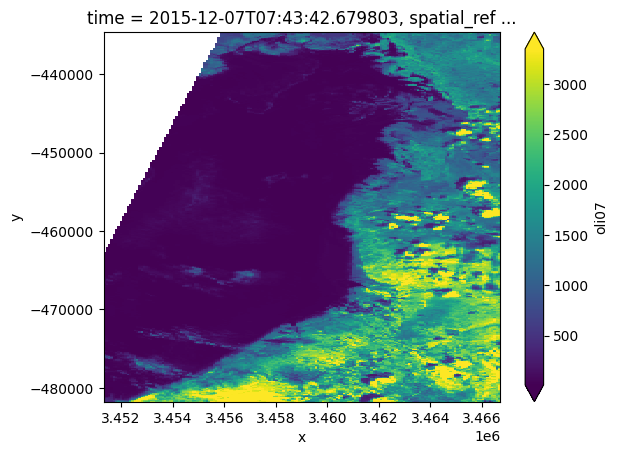

In [87]:
ds_oli.isel(time=0).oli07[50:,50:].plot(robust = True)

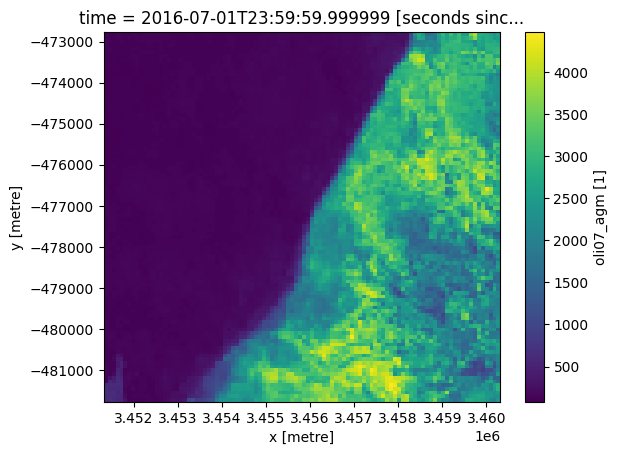

In [73]:
ds_annual.isel(time=1).oli07_agm[50:150,50:150].plot()

16.70657439975051
9.63678003828382
2237.6616801781784
34.19688116173187
1.1933790982302397


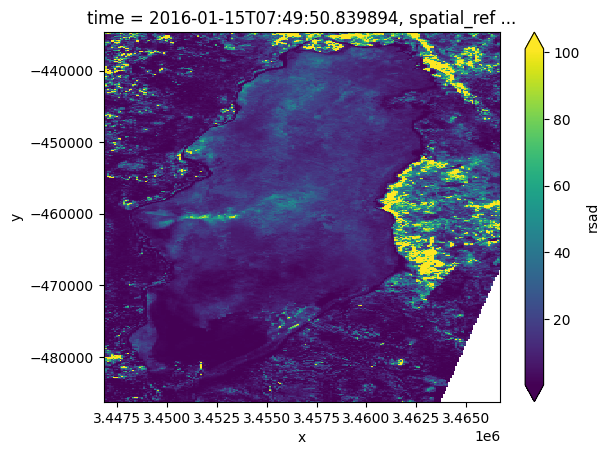

In [151]:
i = i + 1
(ds_oli.isel(time=i).rsad).plot(robust = True)
print(ds_oli.isel(time=i).rsad.mean(dim=('x','y')).item())
print(ds_oli.isel(time=i).rsad.median(dim=('x','y')).item())
print(ds_oli.isel(time=i).rsad.max(dim=('x','y')).item())
print(ds_oli.isel(time=i).rsad.quantile(.9,dim=('x','y')).item())
print(ds_oli.isel(time=i).rsad.quantile(.1,dim=('x','y')).item())

In [152]:
for q in np.arange(0,1.,.1):
    print(ds_oli.oli_qa_rsad.isel(time=i).quantile(q,dim=('x','y')).item())

0.009537953774594099
1.1933790982302397
2.602384257289336
4.612021536053068
7.066688109257616
9.63678003828382
12.594479952546525
16.036109785219434
21.061816325185774
34.19688116173187


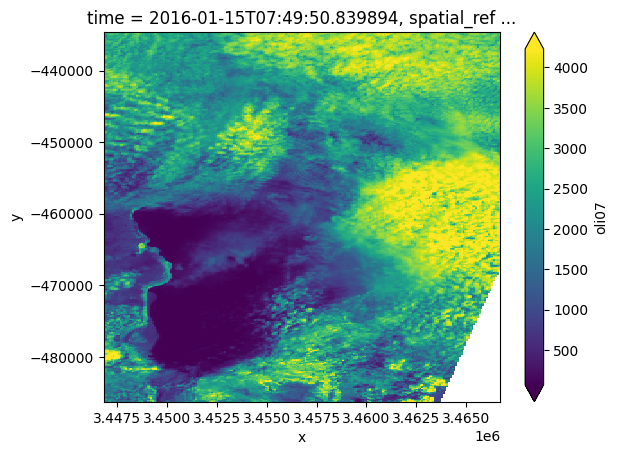

In [155]:

ds_oli.isel(time=i).oli07.plot(robust = True)

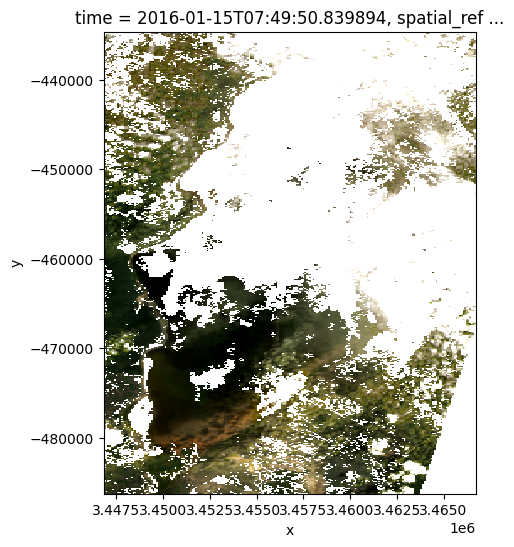

In [156]:
lower = -0.5; upper = 0.3
lower = -.9; 
upper = .75 # upper looks okay to not filter out tubid plumes (0.75), but misses some clouds
upper = .75 # upper looks okay to not filter out tubid plumes (0.75), but misses some clouds
lower = -0.9;
lower =  -10;   #-7.5 cuts out dark, but some water edges get lost .... preserve dark water
upper =  9.5; # 1.4 - 1.6 3.0 would be great but would let through cloud. ..this preserves bright plumes and lets through few clouds

rgb(ds_oli.where(np.logical_and(ds_oli['oli_qa_rsad']>lower,ds_oli['oli_qa_rsad']<upper),np.nan),
    bands=['oli04','oli03','oli02'],
    index = i,
    index_dim='time',
    #robust=True,
    aspect = .8,
   percentile_stretch = (.05,.95)
   )

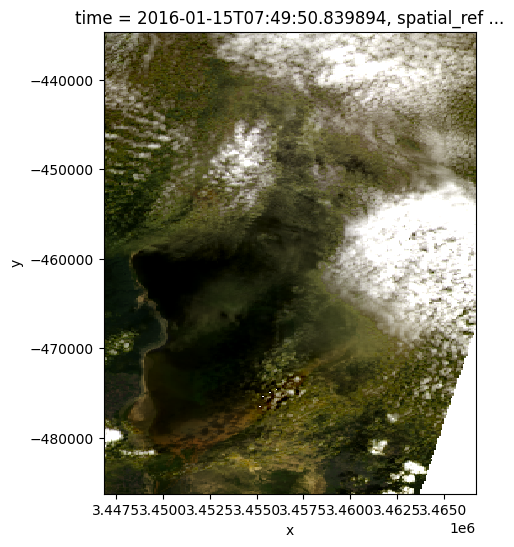

In [157]:

rgb(ds_oli,
    bands=['oli04','oli03','oli01'],
    index = i,
    index_dim='time',
    #robust=True,
    aspect = .8,
   percentile_stretch = (.05,.95)
   )

In [389]:
rgb

<function deafrica_tools.plotting.rgb(ds, bands=['red', 'green', 'blue'], index=None, index_dim='time', robust=True, percentile_stretch=None, col_wrap=4, size=6, aspect=None, savefig_path=None, savefig_kwargs={}, **kwargs)>

In [ ]:
def build_wq_dataset(spacetime_domain,instruments_to_use,verbose=True):
    #loads the 'data products' from the data cube collections
    #returns a single, complex dataset of uniform spatial resolution
    if verbose : print('\nBuilding the dataset:')
    
    products = { 
                'tm_agm'  :["gm_ls5_ls7_annual"],
                'tm'      :["ls5_sr","ls7_sr"],
                'oli_agm' :["gm_ls8_annual","gm_ls8_ls9_annual"],
                'oli'     :["ls8_sr","ls9_sr"],
                'msi_agm' :["gm_s2_annual"],
                'msi'     :["s2_l2a"],
                'tirs'    :["ls5_st","ls7_st","ls8_st","ls9_st"],
                'wofs_ann':["wofs_ls_summary_annual"],
                'wofs_all':["wofs_ls_summary_alltime"],
               }

    
    
    
    instruments,measurements,rename_dict = instruments_list(instruments_to_use) 
    datasets = {}
    for instrument in list(instruments_to_use.keys()):
        if instruments_to_use[instrument]['use'] :
            if verbose : print('loading data for ',instrument,'...')
            
            
            datasets[instrument] = dc.load(product=(products[instrument]),
                                 **spacetime_domain,
                                 **{'measurements': measurements[instrument]},
                                 output_crs='epsg:6933',
                                 group_by ='solar_day',
                                 resolution=grid_resolution,
                                 align=(0,0),
                                 resampling=resampling_option,)
    
    #rename the measurements to standardised variable names,
    for instrument in list(instruments_to_use.keys()):
        if instruments_to_use[instrument]['use']:      
            datasets[instrument] = rename_vars_robust(datasets[instrument],rename_dict[instrument],False)
    
    return(datasets)
    
    # .... and build a list of datasets to merge:
    mergelist = []; i = 0
    first = True
    for instrument in list(instruments_to_use.keys()):
        if instruments_to_use[instrument]['use'] and not instrument == 'tirs':      
            #datasets[instrument] = rename_vars_robust(datasets[instrument],rename_dict[instrument],False)       
            if first :
                first = False
                dataset = datasets[instrument]
            else:
                dataset = dataset.combine_first(datasets[instrument])
            mergelist.append(datasets[instrument])    
     
    

In [191]:
ds_annual

NameError: name 'ds_annual' is not defined

In [157]:
dsets = build_wq_dataset(spacetime_domain,instruments_to_use,verbose = verbose)

# --- retain a dictionary of the instruments and measurements that are on-hand ---
instruments    = instruments_list(instruments_to_use)[0]  # a list of the instruments  in use
            


Building the dataset:
loading data for  oli_agm ...
loading data for  oli ...
loading data for  tirs ...
loading data for  wofs_ann ...
loading data for  wofs_all ...


In [ ]:
#try load_ard
# Create a reusable query
query = {
    'x': (-16.45, -16.6),
    'y': (13.675, 13.8),
    'time': ('2021-09', '2021-12'),
    'measurements': ['red', 'green', 'blue'],
    'group_by': 'solar_day',
    'output_crs' : 'epsg:6933',
}

In [75]:
from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import rgb

In [180]:
# Load available data from all three Landsat satellites
load_ard(dc=dc,
              products=['ls5_sr',
                        'ls7_sr',
                        'ls8_sr',
                        'ls9_sr'],
              resolution=grid_resolution,
              resampling = resampling_option,
              output_crs='epsg:6933',
              group_by ='solar_day',                                 
              **spacetime_domain,
              mask_pixel_quality = False,
              align = (0.0)
             )


Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls5_sr
    ls7_sr
    ls8_sr
    ls9_sr
Re-scaling Landsat C2 data
Loading 6 time steps


<xarray.Dataset> Size: 21MB
Dimensions:                 (time: 6, y: 574, x: 221)
Coordinates:
  * time                    (time) datetime64[ns] 48B 2015-12-06T07:50:46.715...
  * y                       (y) float64 5kB -4.862e+05 -4.861e+05 ... -4.347e+05
  * x                       (x) float64 2kB 3.447e+06 3.447e+06 ... 3.467e+06
    spatial_ref             int32 4B 6933
Data variables:
    red                     (time, y, x) float32 3MB nan nan ... 0.08991 0.07082
    green                   (time, y, x) float32 3MB nan nan ... 0.07891 0.06647
    blue                    (time, y, x) float32 3MB nan nan ... 0.05699 0.04555
    nir                     (time, y, x) float32 3MB nan nan ... 0.2081 0.2137
    swir_1                  (time, y, x) float32 3MB nan nan ... 0.2379 0.2135
    swir_2                  (time, y, x) float32 3MB nan nan ... 0.1919 0.1602
    pixel_quality           (time, y, x) uint16 2MB 1 1 1 ... 21824 21824 21824
    radiometric_saturation  (time, y, x) uint16 2MB 0 0 0 0 0 0 ... 0 0 0 0 0 0
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref

In [ ]:
dc.load(product=(products[instrument]),
                                 **spacetime_domain,
                                 **{'measurements': measurements[instrument]},
                                 output_crs='epsg:6933',
                                 group_by ='solar_day',
                                 resolution=grid_resolution,
                                 align=(0,0),
                                 resampling=resampling_option,)

### After extracting the data:
- re-scale  any oli or tm data
- remove outliers
- summarise to month

In [168]:
def rescale_oli_data(ds):
# --- re-scale the oli data --- 
    oli_rescale_vars = ("oli01","oli02","oli03","oli04","oli05","oli06","oli07") 
    for var in (oli_rescale_vars):
        if var in np.asarray(ds.data_vars):
            if verbose or test: print('rescaling',var)
            ds[var] =  ((2.75e-5 * ds[var]) - 0.2 ) * 10000
    return(ds)

In [172]:
temp = rescale_oli_data(dsets['oli'].copy())

rescaling oli01
rescaling oli02
rescaling oli03
rescaling oli04
rescaling oli05
rescaling oli06
rescaling oli07


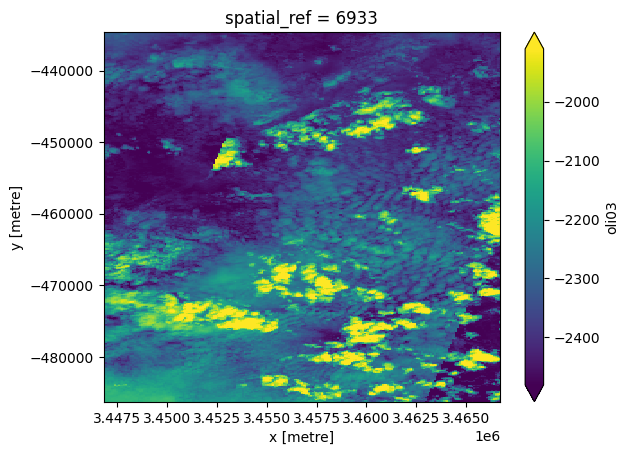

In [175]:
dsets['oli'].oli03.max(dim=('time')).plot(robust=True)

In [146]:
def rescale_tm_data(ds):
# --- re-scale the oli data --- 
    tm_rescale_vars = ("tm01","tm02","oli03","oli04","oli05","oli06","oli07") 
    for var in (oli_rescale_vars):
        if var in np.asarray(ds.data_vars):
            ds[var] =  ((2.75e-5 * ds[var]) - 0.2 ) * 10000
    return(ds)

In [ ]:
rescale_oli_data(ds)

<xarray.DataArray 'time' (time: 6)> Size: 48B
array(['2004-07-01T23:59:59.999999000', '2015-07-02T11:59:59.999999000',
       '2015-12-07T07:43:42.679803000', '2015-12-14T07:49:53.448177000',
       '2015-12-23T07:43:43.494509000', '2015-12-30T07:49:52.823376000'],
      dtype='datetime64[ns]')
Coordinates:
  * time         (time) datetime64[ns] 48B 2004-07-01T23:59:59.999999 ... 201...
    spatial_ref  int32 4B 6933
Attributes:
    units:    seconds since 1970-01-01 00:00:00

In [63]:
from deafrica_tools.plotting import display_map, rgb


In [113]:
ds.oli02_agm.mean()

<xarray.DataArray 'oli02_agm' ()> Size: 8B
array(672.98254686)
Coordinates:
    spatial_ref  int32 4B 6933

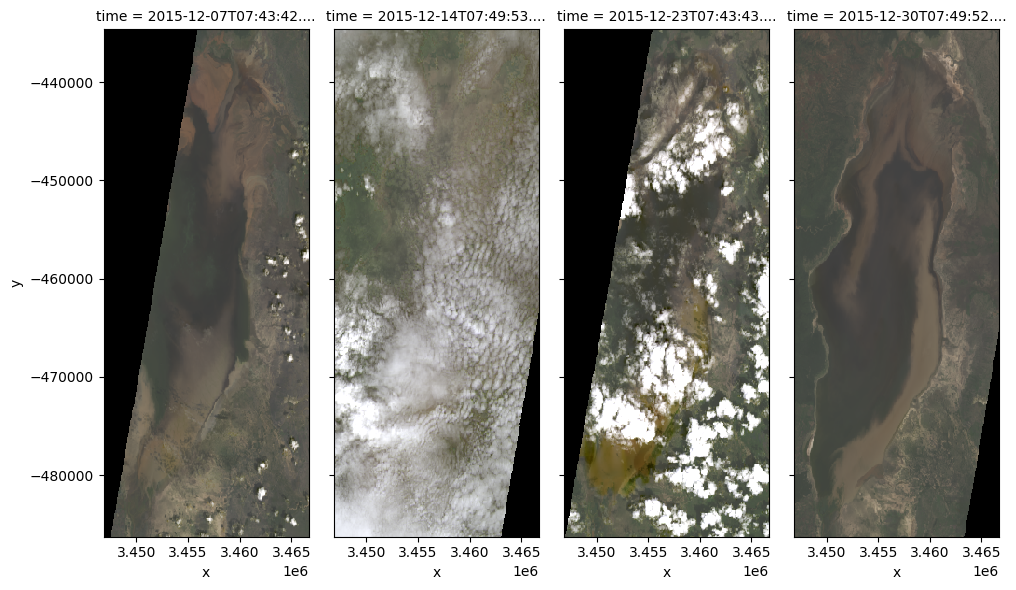

In [70]:
rgb(ds,bands=['oli04','oli03','oli02'],col='time')

### Filter outliers by reference to the geomedian and pq bands



### Determine pixels that are water (sometimes, usually, permanent)

In [64]:
# --- controling parameters for water mapping on a pixel by pixel basis ---
WFTH = water_frequency_threshold_high = 0.5    #this threshold targets areas that are as like as not to be water at any time.
WFTL = water_frequency_threshold_low  = 0.1    #for pixel processing (rather than during summation)
PWT  = permanent_water_threshold      = 0.875  #used to map annual permanent water (value arrived at through testing)
SC   = sigma_coefficient              = 1.2    #used to map annual permanent water (value arrived at through tessting)
ds   = water_analysis(ds,
                   water_frequency_threshold= WFTH,
                   wofs_varname             = 'wofs_ann_freq',
                   permanent_water_threshold= PWT,
                   sigma_coefficient        = SC,
                   verbose                  = verbose,
                   test                     = test)

/opt/venv/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:236: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


### Pixel corrections

In [16]:
# --- dark Pixel correction, the 'dp_adjust' dictionary controls which variables are used as a reference, 
#     and which are changed in the dark-pixel correction
#     Add entries to cater for non-geomedian situations.

dp_adjust = { 
        'msi_agm': {'ref_var':'msi12_agm','var_list': ['msi04_agm','msi03_agm','msi02_agm','msi05_agm','msi06_agm', 'msi07_agm']},
        'oli_agm': {'ref_var':'oli07_agm','var_list': ['oli04_agm','oli03_agm','oli02_agm']},
        'tm_agm' : {'ref_var':'tm07_agm', 'var_list': ['tm04_agm','tm03_agm','tm02_agm','tm01_agm']}
        }
ds = R_correction(ds,dp_adjust,instruments,water_frequency_threshold_low,verbose=verbose,test=test)

### Hue; calculation of the hue value

In [17]:
if not (('msi_agm') in instruments.keys()):
    print("skipping hue calculation as the msi_agm instrument is not in the dataset")
else: 
    ds['hue'] = hue_calculation(ds,instrument='msi_agm',test=test,verbose=verbose)[0]

### Optical Water Type (OWT)
The algorithm compares each pixel's band values with 13 reference spectra based on the spectral angle. Therefore, for each pixel 13 dot products are calculated. 
Memory intensive, data are down-sampled for processing. 
Methods as per Spyrakos et al 2018. - code here caters for msi_agm and oli_agm sensors (ie., the annual geomedian), but easily adapted to msi and oli through dictionary entries
OWT is estimated from the spectral angle between the pixel and the refence spectra for each of the 13 OWTs
- extension to other sensors (TM, OLCI) also quite straightforward but the OWT refence data would need to be brought in.

we can do this for Landsat and for Sentinel, however in the geomedian 
- OLI has only 3 available bands (2,3,4) - missing band 1
- MSI has only 6  of 7 useful bands (missing band 1) 
- TM  has 4  (all of 1,2,3,4)

**To do, ideally : Upload the full reference spectra and establish an import function to bring in as a data array.**
- Here, I have estimated the mean band reflectance for each sensor in excell using the spectral response curves (MSI response functions are available on-line) and used the results directly 

#### Zhang et al. group the OWTs as follows:
- oligotrophic (clear)           : 3, 9, 13           (apply NASA OCx model for ChlA) - we don't see much of this!!!
- eutopic and bluegreen waters   : 1, 2, 4, 5, 11, 12 (apply two band models of Gurlin et al for ChlA)
- hypereutrophic and green-brown : 6, 7, 8, 10        (apply TC2 alg for ChlA)   

In [18]:
ds['owt_msi'] = OWT_pixel(ds,'msi_agm',water_frequency_threshold=0.8,resample_rate=3,verbose=False, test=True)        


### Calculate the raw (i.e. not harmonised) water quality measurements and indices
- A dictionary is used to manage water quality algorithms and the bands that are used in them. This retains flexibility (e.g. algorithms can be run with multiple sensors) and avoids errors
- NEW DIMENSIONS are added to the dataset to house the results. One dimension is added called 'chla', and one called 'tss'. This appraoch simplifies later processing when we want to pool the measures as an ensemble. (For simplicity, I may remove this and bring in at a later stage..)



In [19]:
# ----  dictionary of instruments, bands, algorithms, and  functions -----------------------   

ndci_nir_r   =  { 
                "msi_agm"   : {'54' : {'func': NDCI_NIR_R, "wq_varname" : 'ndci_msi54_agm'       ,'args' : {"NIR_band" : 'msi05_agmr', "red_band":'msi04_agmr'}},
                               '64' : {'func': NDCI_NIR_R, "wq_varname" : 'ndci_msi64_agm'       ,'args' : {"NIR_band" : 'msi06_agmr', "red_band":'msi04_agmr'}},
                               '74' : {'func': NDCI_NIR_R, "wq_varname" : 'ndci_msi74_agm'       ,'args' : {"NIR_band" : 'msi07_agmr', "red_band":'msi04_agmr'}}},
                "tm_agm"    : {'func': NDCI_NIR_R, "wq_varname" : 'ndci_tm43_agm'                ,'args' : {"NIR_band" : 'tm04_agm'  , "red_band":'tm03_agmr'}},
                "oli_agm"   : {'func': NDCI_NIR_R, "wq_varname" : 'ndci_oli54_agm'               ,'args' : {"NIR_band" : 'oli05_agm' , "red_band":'oli04_agmr'}}
                }

chla_meris2b = {"msi_agm" : {'func': ChlA_MERIS2B, "wq_varname" : 'chla_meris2b_msi_agm' ,'args' : {"band_708" : 'msi05_agmr', "band_665":'msi04_agmr'}},
                    "msi"     : {'func': ChlA_MERIS2B, "wq_varname" : 'chla_meris2b_msi'     ,'args' : {"band_708" : 'msi05'     , "band_665":'msi04'}}}

chla_modis2b = {"msi_agm" : {'func': ChlA_MODIS2B, "wq_varname" : 'chla_modis2b_msi_agm' ,'args' : {"band_748" : 'msi06_agmr', "band_667":'msi04_agmr'}},
                    "msi"     : {'func': ChlA_MODIS2B, "wq_varname" : 'chla_modis2b_msi'     ,'args' : {"band_748" : 'msi06'     , "band_667":'msi04'}},
                    "tm_agm"  : {'func': ChlA_MODIS2B, "wq_varname" : 'chla_modis2b_tm_agm'  ,'args' : {"band_748" : 'tm04_agmr' , "band_667":'tm03_agmr'}}}

ndssi_rg     = {"msi_agm" : {'func': NDSSI_RG,     "wq_varname" : 'ndssi_rg_msi_agm'       ,'args' : { "red_band":'msi04_agmr', "green_band":'msi03_agmr'}},
                "msi"     : {'func': NDSSI_RG,     "wq_varname" : 'ndssi_rg_msi'           ,'args' : { "red_band":'msi04r'    , "green_band":'msi03_agmr'}},
                "oli_agm" : {'func': NDSSI_RG,     "wq_varname" : 'ndssi_rg_oli_agm'       ,'args' : { "red_band":'oli04_agmr', "green_band":'oli03_agmr'}},
                "oli"     : {'func': NDSSI_RG,     "wq_varname" : 'ndssi_rg_oli'           ,'args' : { "red_band":'oli04r'    , "green_band":'oli03r'    }},
                "tm_agm"  : {'func': NDSSI_RG,     "wq_varname" : 'ndssi_rg_tm_agm'        ,'args' : { "red_band":'tm03_agmr' , "green_band":'tm02_agmr' }},
                "tm"      : {'func': NDSSI_RG,     "wq_varname" : 'ndssi_rg_tm'            ,'args' : { "red_band":'tm03r'     , "green_band":'tmi02r'    }}}

ndssi_bnir   = {#"msi_agm" : {'func': NDSSI_BNIR,   "wq_varname" : 'ndssi_bnir_msi_agm'     ,'args' : { "NIR_band":'msi08_agmr', "blue_band":'msi02_agmr'}},
                "msi"     : {'func': NDSSI_BNIR,   "wq_varname" : 'ndssi_bnir_msi'         ,'args' : { "NIR_band":'msi08'     , "blue_band":'msi02_agmr'}},
                "oli_agm" : {'func': NDSSI_BNIR,   "wq_varname" : 'ndssi_bnir_oli_agm'     ,'args' : { "NIR_band":'oli06_agm' , "blue_band":'oli02_agmr'}},
                "oli"     : {'func': NDSSI_BNIR,   "wq_varname" : 'ndssi_bnir_oli'         ,'args' : { "NIR_band":'oli06'     , "blue_band":'oli02r'    }},
                #"tm_agm"  : {'func': NDSSI_BNIR,   "wq_varname" : 'ndssi_bnir_tm_agm'      ,'args' : { "NIR_band":'tm04_agm'  , "blue_band":'tm01_agmr' }},
                "tm"      : {'func': NDSSI_BNIR,   "wq_varname" : 'ndssi_bnir_tm'          ,'args' : { "NIR_band":'tm04'     , "blue_band":'tm01r'    }}}


ti_yu        = {#"msi_agm" : {'func': TI_yu,        "wq_varname" : 'ti_yu_msi_agm'        ,'args' : {"NIR" : 'msi08_agmr', "Red":'msi04_agmr', "Green":'msi03_agmr'}},
                    "msi"     : {'func': TI_yu,        "wq_varname" : 'ti_yu_msi'            ,'args' : {"NIR" : 'msi08'     , "Red":'msi04r'    , "Green":'msi03_agmr'}},
                    "oli_agm" : {'func': TI_yu,        "wq_varname" : 'ti_yu_oli_agm'        ,'args' : {"NIR" : 'oli06_agm' , "Red":'oli04_agmr', "Green":'oli03_agmr'}},
                    "oli"     : {'func': TI_yu,        "wq_varname" : 'ti_yu_oli'            ,'args' : {"NIR" : 'oli06'     , "Red":'oli04r'    , "Green":'oli03r'    }},
                    "tm_agm"  : {'func': TI_yu,        "wq_varname" : 'ti_yu_tm_agm'         ,'args' : {"NIR" : 'tm04_agm'  , "Red":'tm03_agmr' , "Green":'tm02_agmr' }},
                    "tm"      : {'func': TI_yu,        "wq_varname" : 'ti_yu_tm'             ,'args' : {"NIR" : 'tm04'      , "Red":'tm03r'     , "Green":'tmi02r'    }}}

tsm_lym      = {"oli_agm" : {'func': TSM_LYM_OLI,  "wq_varname" : 'tsm_lym_oli_agm'        ,'args' : {"red_band":'oli04_agmr', "green_band":'oli03_agmr'}},
                    "oli"     : {'func': TSM_LYM_OLI,  "wq_varname" : 'tsm_lym_oli'            ,'args' : {"red_band":'oli04r'    , "green_band":'oli03r'    }},
                    "msi_agm" : {'func': TSM_LYM_OLI,  "wq_varname" : 'tsm_lym_msi_agm'        ,'args' : {"red_band":'msi04_agmr', "green_band":'msi03_agmr' }},
                    "msi"     : {'func': TSM_LYM_OLI,  "wq_varname" : 'tsm_lym_msi'            ,'args' : {"red_band":'msi04r'    , "green_band":'msi03r'    }},
                    "tm_agm"  : {'func': TSM_LYM_ETM,  "wq_varname" : 'tsm_lym_tm_agm'         ,'args' : {"red_band":'tm03_agmr' , "green_band":'tm02_agmr' }},
                    "tm"      : {'func': TSM_LYM_ETM,  "wq_varname" : 'tsm_lym_tm'             ,'args' : {"red_band":'tm03r'     , "green_band":'tm02r'     }}}

spm_qiu      = {"oli_agm" : {'func': SPM_QIU,  "wq_varname" : 'spm_qiu_oli_agm'        ,'args' : {"red_band":'oli04_agmr', "green_band":'oli03_agmr'}},
                    "oli"     : {'func': SPM_QIU,  "wq_varname" : 'spm_qiu_oli'            ,'args' : {"red_band":'oli04r'    , "green_band":'oli03r'    }},
                    "tm_agm"  : {'func': SPM_QIU,  "wq_varname" : 'spm_qiu_tm_agm'         ,'args' : {"red_band":'tm03_agmr' , "green_band":'tm02_agmr' }},
                    "tm"      : {'func': SPM_QIU,  "wq_varname" : 'spm_qiu_tm'             ,'args' : {"red_band":'tm03r'     , "green_band":'tm02r'     }},
                    "msi_agm" : {'func': SPM_QIU,  "wq_varname" : 'spm_qiu_msi_agm'        ,'args' : {"red_band":'msi04_agmr', "green_band":'msi03_agmr'}},
                    "msi"     : {'func': SPM_QIU,  "wq_varname" : 'spm_qiu_msi'            ,'args' : {"red_band":'msi04r'    , "green_band":'msi03r'    }}}

tss_zhang        = {"msi_agm" : {'func': TSS_Zhang, "wq_varname" : 'tss_zhang_msi_agm' ,'args' : {"blue_band" : 'msi02_agmr', "red_band":'msi04_agmr', "green_band":'msi03_agmr'}},
                        "msi"     : {'func': TSS_Zhang, "wq_varname" : 'tss_zhang_msi'     ,'args' : {"blue_band" : 'msi02r'    , "red_band":'msi04r'    , "green_band":'msi03_agmr'}},
                        "oli_agm" : {'func': TSS_Zhang, "wq_varname" : 'tss_zhang_oli_agm' ,'args' : {"blue_band" : 'oli02_agmr', "red_band":'oli04_agmr', "green_band":'oli03_agmr'}},
                        "oli"     : {'func': TSS_Zhang, "wq_varname" : 'tss_zhang_oli'     ,'args' : {"blue_band" : 'oli02r'    , "red_band":'oli04r'    , "green_band":'oli03r'    }}}

# ---- algorithms are grouped into two over-arching dictionaries ---- 
algorithms_chla = {"ndci_nir_r"   : ndci_nir_r, 
                       "chla_meris2b" : chla_meris2b, 
                       "chla_modis2b" : chla_modis2b}
algorithms_tsm  = {"ndssi_rg"     : ndssi_rg  , 
                       "ndssi_bnir"   : ndssi_bnir, 
                       "ti_yu"        : ti_yu     ,
                       "tsm_lym"      : tsm_lym   ,
                       "tss_zhang"    : tss_zhang ,
                       "spm_qiu"      : spm_qiu    }

In [20]:
# ---- Apply the WQ algorithms to water areas, adding variables to the dataset and building  a list of water quality variable nanmes
# -- this can be run either keeping the wq variables as separate variables on the dataset, or by moving them into new dimensions, 'tss' and 'chla'
# -- If the arguments 'new_dimension_name' or 'new_varname' are None (or empty), then the outputs will be retained as separate variables in a 3d dataset

if True: #put the data into a new dimension, call the variable 'tss' or 'chla'
    ds,tsm_vlist  = WQ_vars(ds.where(ds.wofs_ann_freq >= water_frequency_threshold_low),
                        algorithms_tsm,  
                        instruments, 
                        new_dimension_name='tss_measure', 
                        new_varname='tss', 
                        verbose=verbose)
    ds,chla_vlist = WQ_vars(ds.where(ds.wofs_ann_freq >= water_frequency_threshold_low),
                        algorithms_chla, 
                        instruments, 
                        new_dimension_name='chla_measure', 
                        new_varname='chla',
                        verbose=verbose)

else:  #keep it simple, just add new data as new variables in a 3-D dataset 
    ds,tsm_vlist  = WQ_vars(ds.where(ds.wofs_ann_freq >= water_frequency_threshold_low),
                        algorithms_tsm,  
                        instruments, 
                        new_dimension_name=None, 
                        new_varname=None, 
                        verbose=verbose)
    ds,chla_vlist = WQ_vars(ds.where(ds.wofs_ann_freq >= water_frequency_threshold_low),
                        algorithms_chla, 
                        instruments, 
                        new_dimension_name=None, 
                        new_varname=None,
                        verbose=verbose)
wq_varlist = np.append(tsm_vlist,chla_vlist)


In [21]:
# ---- tidy up by dropping excess variables ---
keeplist = ('wofs_ann_clearcount','wofs_ann_wetcount','wofs_ann_freq','wofs_ann_freq_sigma','wofs_pw_threshold','wofs_ann_pwater','watermask','owt_msi','tss','chla')
#the keeplist is not complete; if the wq variables are retained as variables they will appear in a listing of data_vars. 
#therefore, revert to the instruments dictionary to list variables to drop
droplist = []
for instrument in list(instruments.keys()):
    for band in list(instruments[instrument].keys()):
        variable = instruments[instrument][band]['varname']
        if not (variable in keeplist): 
            droplist=np.append(droplist,variable)
            droplist=np.append(droplist,variable+'r')
for varname in droplist:
    if varname in ds.data_vars:
        ds = ds.drop_vars(varname)
    

### And we are Done... :)

In [22]:
#export the dataset as an input for the next step:
ds.to_netcdf("../WP1.4/wp12_ds_"+placename+".nc")

In [23]:
ds.data_vars

Data variables:
    wofs_ann_freq        (time, y, x) float32 235kB nan nan nan ... nan nan nan
    wofs_ann_clearcount  (time, y, x) float64 470kB nan nan nan ... nan nan nan
    wofs_ann_wetcount    (time, y, x) float64 470kB nan nan nan ... nan nan nan
    wofs_ann_freq_sigma  (time, y, x) float64 470kB nan nan nan ... nan nan nan
    wofs_ann_confidence  (time, y, x) float32 235kB nan nan nan ... nan nan nan
    wofs_pw_threshold    (time, y, x) float64 470kB nan nan nan ... nan nan nan
    wofs_ann_pwater      (time, y, x) float32 235kB nan nan nan ... nan nan nan
    wofs_ann_water       (time, y, x) float32 235kB nan nan nan ... nan nan nan
    watermask            (time, y, x) float64 470kB nan nan nan ... nan nan nan
    hue                  (time, y, x) float64 470kB nan nan nan ... nan nan nan
    owt_msi              (time, y, x) float64 470kB nan nan nan ... nan nan nan
    tss                  (time, y, x, tss_measure) float64 7MB nan nan ... nan
    chla                 

In [24]:
ds['wofs_ann_confidence'] = ((1.0 - (ds.wofs_ann_freq_sigma/ds.wofs_ann_freq)) * 100).astype('int16')

/opt/venv/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:236: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


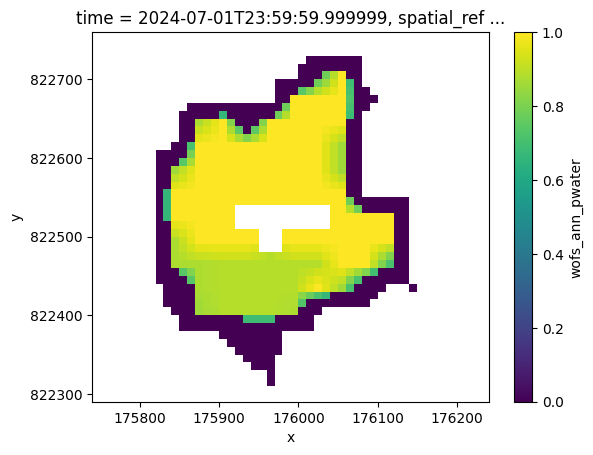

In [25]:
ds.isel(time=24).wofs_ann_pwater.plot()